# Sunspots Data Predict

## Colab Setting

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Fri Jan 22 15:56:37 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Import Library

In [3]:
!pip install pytorch-lightning

     |████████████████████████████████| 686kB 18.4MB/s 
     |████████████████████████████████| 102kB 15.1MB/s 
     |████████████████████████████████| 829kB 53.0MB/s 
     |████████████████████████████████| 645kB 52.7MB/s 
     |████████████████████████████████| 1.3MB 55.9MB/s 
     |████████████████████████████████| 296kB 54.0MB/s 
     |████████████████████████████████| 143kB 62.1MB/s 
  Created wheel for future: filename=future-0.18.2-cp36-none-any.whl size=491057 sha256=14947f5cf792d2044b8437dffdcbdce1e2eae639747f57bd05ab81956de89a0b
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
  Created wheel for idna-ssl: filename=idna_ssl-1.1.0-cp36-none-any.whl size=3163 sha256=e543248ab660de06b3a6a30252039af03a50ab9d5491487b8803dc73b5c65f64
  Stored in directory: /root/.cache/pip/wheels/d3/00/b3/32d613e19e08a739751dd6bf998cfed277728f8b2127ad4eb7
Successfully built future idna-ssl
  Found existing installation: future 0.16.0
    Uni

In [4]:
%cd drive/MyDrive/Research3/train

/content/drive/MyDrive/Research3/train


In [5]:
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.nn import functional as F

import pytorch_lightning as pl
from pytorch_lightning.metrics import functional as FM

import GetData
from BaseModel import BaseModel

## Define Model

In [6]:
class Model(BaseModel):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.rnn = nn.LSTM(1, 64, 2, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(64, 32),
            nn.ELU(),
            nn.Linear(32, 1)
        )
        
    def forward(self, X):
        X, (hn, cn) = self.rnn(X)
        return self.fc(X[:, -1, :])
    
    def test_epoch_end(self, outputs):
        h, y = zip(*outputs)
        h = torch.flatten(torch.cat(h, 0)).cpu().numpy()
        y = torch.flatten(torch.cat(y, 0)).cpu().numpy()
        plt.scatter(y, h)
        plt.show()

## Train And Predict

In [8]:
data_module = GetData.SunspotData(1320, batch_size=128)
model = Model(F.mse_loss, metrics_fn=[(FM.mean_absolute_error, 'mae')])
trainer = pl.Trainer(gpus=1, max_epochs=100)

/usr/local/lib/python3.6/dist-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: You have set progress_bar_refresh_rate < 20 on Google Colab. This may crash. Consider using progress_bar_refresh_rate >= 20 in Trainer.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [9]:
trainer.fit(model, datamodule=data_module)


  | Name | Type       | Params
------------------------------------
0 | rnn  | LSTM       | 50.4 K
1 | fc   | Sequential | 2.1 K 
------------------------------------
52.5 K    Trainable params
0         Non-trainable params
52.5 K    Total params


1

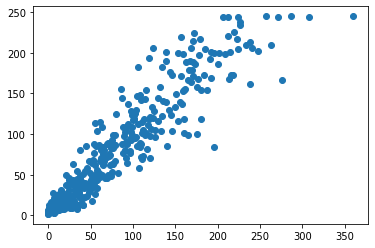


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'loss/test': tensor(616.5636, device='cuda:0'),
 'mae/test': tensor(17.0485, device='cuda:0')}
--------------------------------------------------------------------------------


[{'loss/test': 616.5635986328125, 'mae/test': 17.048538208007812}]

In [10]:
trainer.test(datamodule=data_module)